In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

inv = np.linalg.inv

In [2]:
# Load data
year, month, time, co2 = np.loadtxt("A1_co2.txt", delimiter=' ', skiprows=1, unpack=True)
year = year.astype(int)
month = month.astype(int)

# Index data by indices. 12 months per year
p = 12
time = np.arange(len(time))

# Split into test and train
test_idx = year >= 2018
time_test, co2_test = time[test_idx], co2[test_idx]
time_train, co2_train = time[~test_idx], co2[~test_idx]

train_n = len(time_train)


# 1.2

In [3]:
# Create design matrix (n x 4) and labels (n x 1)
X_train = np.column_stack((np.ones_like(time_train), 
                           time_train, 
                           np.sin(2 * np.pi / p * time_train),
                           np.cos(2 * np.pi / p * time_train)))
y_train = co2_train[:, None]

param_n = X_train.shape[1]

Parameters:
 [[3.06928362e+02]
 [1.28374044e-01]
 [1.69090265e+00]
 [2.25306869e+00]]


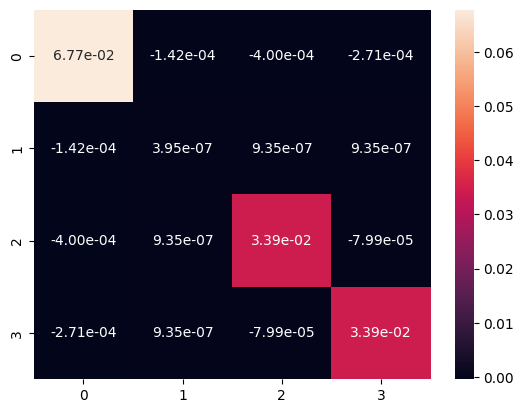

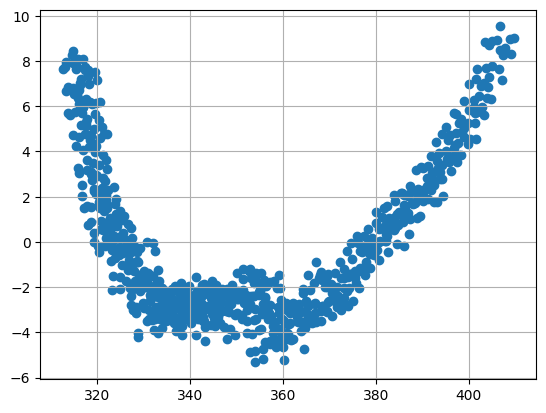

In [4]:
# Estimate parameters for OLS model
ols_param = inv(X_train.T @ X_train) @ X_train.T @ y_train
ols_res = y_train - X_train @ ols_param
ols_var = ols_res.T @ ols_res / (train_n - param_n)
ols_param_var = ols_var * inv(X_train.T @ X_train)

# Print parameters
print("Parameters:\n", ols_param)

# Plot covariance matrix
sns.heatmap(ols_param_var, annot=True, fmt='.2e')
plt.show()

# Plot residuals as a function of y
plt.scatter(y_train, ols_res)
plt.grid()
plt.show()

In [5]:
# Estimate rho parameter for WLS model
wls_rho = 0

wls_sigma_ctr = lambda rho: np.array(
    [[rho**(abs(e - o % train_n)) 
      for e in range(train_n)] 
     for o in range(train_n)]
)


# Do five iterations of the relaxation algorthim
# NOTE: One additional iteration to store final parameters
for i in range(5+1):
    # Create covariance matrix
    wls_sigma = wls_sigma_ctr(wls_rho)
    wls_sigma_inv = inv(wls_sigma)

    # Estimate parameters for WLS model
    wls_param = inv(X_train.T @ wls_sigma_inv @ X_train) @ X_train.T @ wls_sigma_inv @ y_train
    # Get residuals
    wls_res = y_train - X_train @ wls_param

    # Estimate new rho
    wls_rho = np.corrcoef(wls_res[:-1, 0], wls_res[1:, 0])[0, 1]

    print(wls_rho)

0.9820921007263153
0.9822410526176433
0.9822427429486463
0.9822427623072223
0.98224276252896
0.982242762531475


Parameters:
 [[3.07470864e+02]
 [1.29839150e-01]
 [1.66890379e+00]
 [2.29457132e+00]]


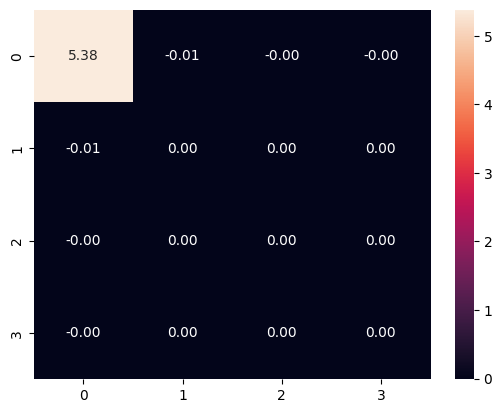

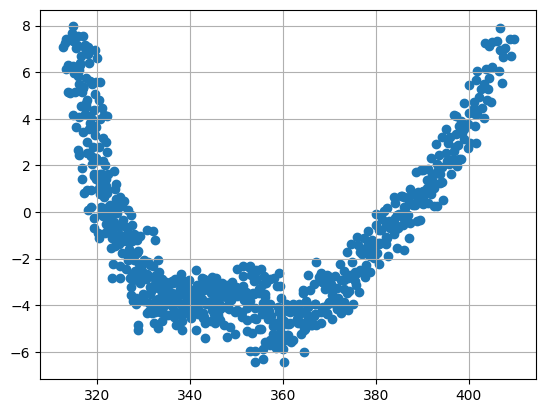

In [6]:
# Estimate variance of residuals
# NOTE: Subtracting one more because also estimating rho
wls_var = wls_res.T @ wls_sigma_inv @ wls_res / (train_n - len(wls_param) - 1)
# Estimate variance of parameters
wls_param_var = wls_var * inv(X_train.T @ wls_sigma_inv @ X_train)


# Print parameters
print("Parameters:\n", wls_param)

# Plot covariance matrix
sns.heatmap(wls_param_var, annot=True, fmt='.2f')
plt.show()

# Plot residuals as a function of y
plt.scatter(y_train, wls_res)
plt.grid()
plt.show()

# 1.3

$$ f(t+1) = L f(t) $$

$$
    f(0) = \begin{bmatrix} 
        1 \\
        0 \\
        sin(\frac{2 \pi}{12} \cdot 0) \\
        cos(\frac{2 \pi}{12} \cdot 0)
    \end{bmatrix}
$$

$$
    f(t) = \begin{bmatrix} 
        1 \\
        t \\
        sin(\frac{2 \pi}{12} t) \\
        cos(\frac{2 \pi}{12} t)
    \end{bmatrix}\\

    L = \begin{bmatrix}
        1 & 0 &                        0 &                       0\\
        1 & 1 &                        0 &                       0\\
        0 & 0 &  cos(\frac{2 \pi}{12}) & sin(\frac{2 \pi}{12})\\
        0 & 0 & -sin(\frac{2 \pi}{12}) & cos(\frac{2 \pi}{12})\\
    \end{bmatrix}\\

    f(t+1) = \begin{bmatrix} 
        1 \\
        t+1 \\
        sin(\frac{2 \pi}{12} (t+1)) \\
        cos(\frac{2 \pi}{12} (t+1))
    \end{bmatrix}
$$

In [7]:
# Amount of data to skip predictions for
burn_in_1 = 10


def llt_predict(start = 10, lamb = 0.9):
    # Store predictions
    llt_y_pred_train = []
    llt_y_pred_train_mean = []

    # Create transition matrix
    L = np.array([[1, 0, 0, 0],
                  [1, 1, 0, 0],
                  [0, 0,  np.cos(2 * np.pi / p), np.sin(2 * np.pi / p)],
                  [0, 0, -np.sin(2 * np.pi / p), np.cos(2 * np.pi / p)]])
    L_inv = inv(L)

    # Create design matrix for t'th time step
    f_i = lambda t: np.array([1, t, np.sin(2 * np.pi / p * t), np.cos(2 * np.pi / p * t)])[:, None]
    # Cache "current" time step
    f_0 = f_i(0)

    # Calculate initial F_i and h_i, where i = start
    x_start = np.array([f_i(t).squeeze() for t in range(-start+1, 0+1)])
    sigma_inv = np.diag([lamb**t for t in range(start-1, 0-1, -1)])
    F_i = x_start.T @ sigma_inv @ x_start
    h_i = x_start.T @ sigma_inv @ y_train[:start]


    # Go through each data point and make one-step predictions
    for i in range(start+1, len(X_train)):
        # Incremental update solution
        # ############################
        # Add in next old "x^2" since more data is now "in the past"
        F_i = F_i + lamb**(i-1) * f_i(-(i-1)) @ f_i(-(i-1)).T
        # Subtracting by 1 because Python is zero indexed, so newest point is really i-1
        h_i = lamb * L_inv @ h_i + (f_0 @ y_train[i-1])[:, None]
        
        # # Naive solution that recomputes everything
        # ############################
        # x_start = np.array([f_i(t).squeeze() for t in range(-i+1, 0+1)])
        # sigma_inv = np.diag([lamb**t for t in range(i-1, 0-1, -1)])
        # F_i = x_start.T @ sigma_inv @ x_start
        # h_i = x_start.T @ sigma_inv @ train_y[:i, None]


        # Calculate parameters
        theta_i = np.linalg.inv(F_i) @ h_i

        # Make one step prediction for current step
        y_i = f_0.T @ theta_i


        # Store predictions
        llt_y_pred_train.append(y_i[0, 0])
        llt_y_pred_train_mean.append(theta_i[0, 0])


    # Make predictions for test data
    llt_y_pred_test = np.array([f_i(t).squeeze() for t in range(len(time_test))]) @ theta_i


    # Return predictions
    return np.array(llt_y_pred_train), np.array(llt_y_pred_train_mean), np.array(llt_y_pred_test)


# Retrieve predictions
llt_y_pred_train, llt_y_pred_train_mean, llt_y_pred_test = llt_predict(start = burn_in_1, lamb = 0.9)

# 1.4


100%|██████████| 1000/1000 [00:10<00:00, 91.27it/s]


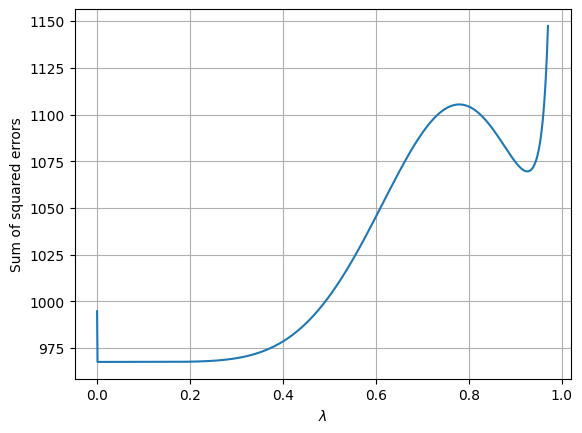

In [8]:
# Set ranges of points to skip and lambdas to test
burn_in_2 = 100
lambs = np.linspace(0+2e-4, 1-3e-2, 1000)

# Predict and calculate squared error for each lambda
sqerrors = [((y_train[burn_in_2+1:, 0] - llt_predict(start=burn_in_2, lamb=l)[0])**2).sum() for l in tqdm(lambs)]

# Plot squared error as a function of lambda
plt.plot(lambs, sqerrors)

plt.grid()
plt.xlabel('$\lambda$')
plt.ylabel('Sum of squared errors')

plt.show()

# 1.1

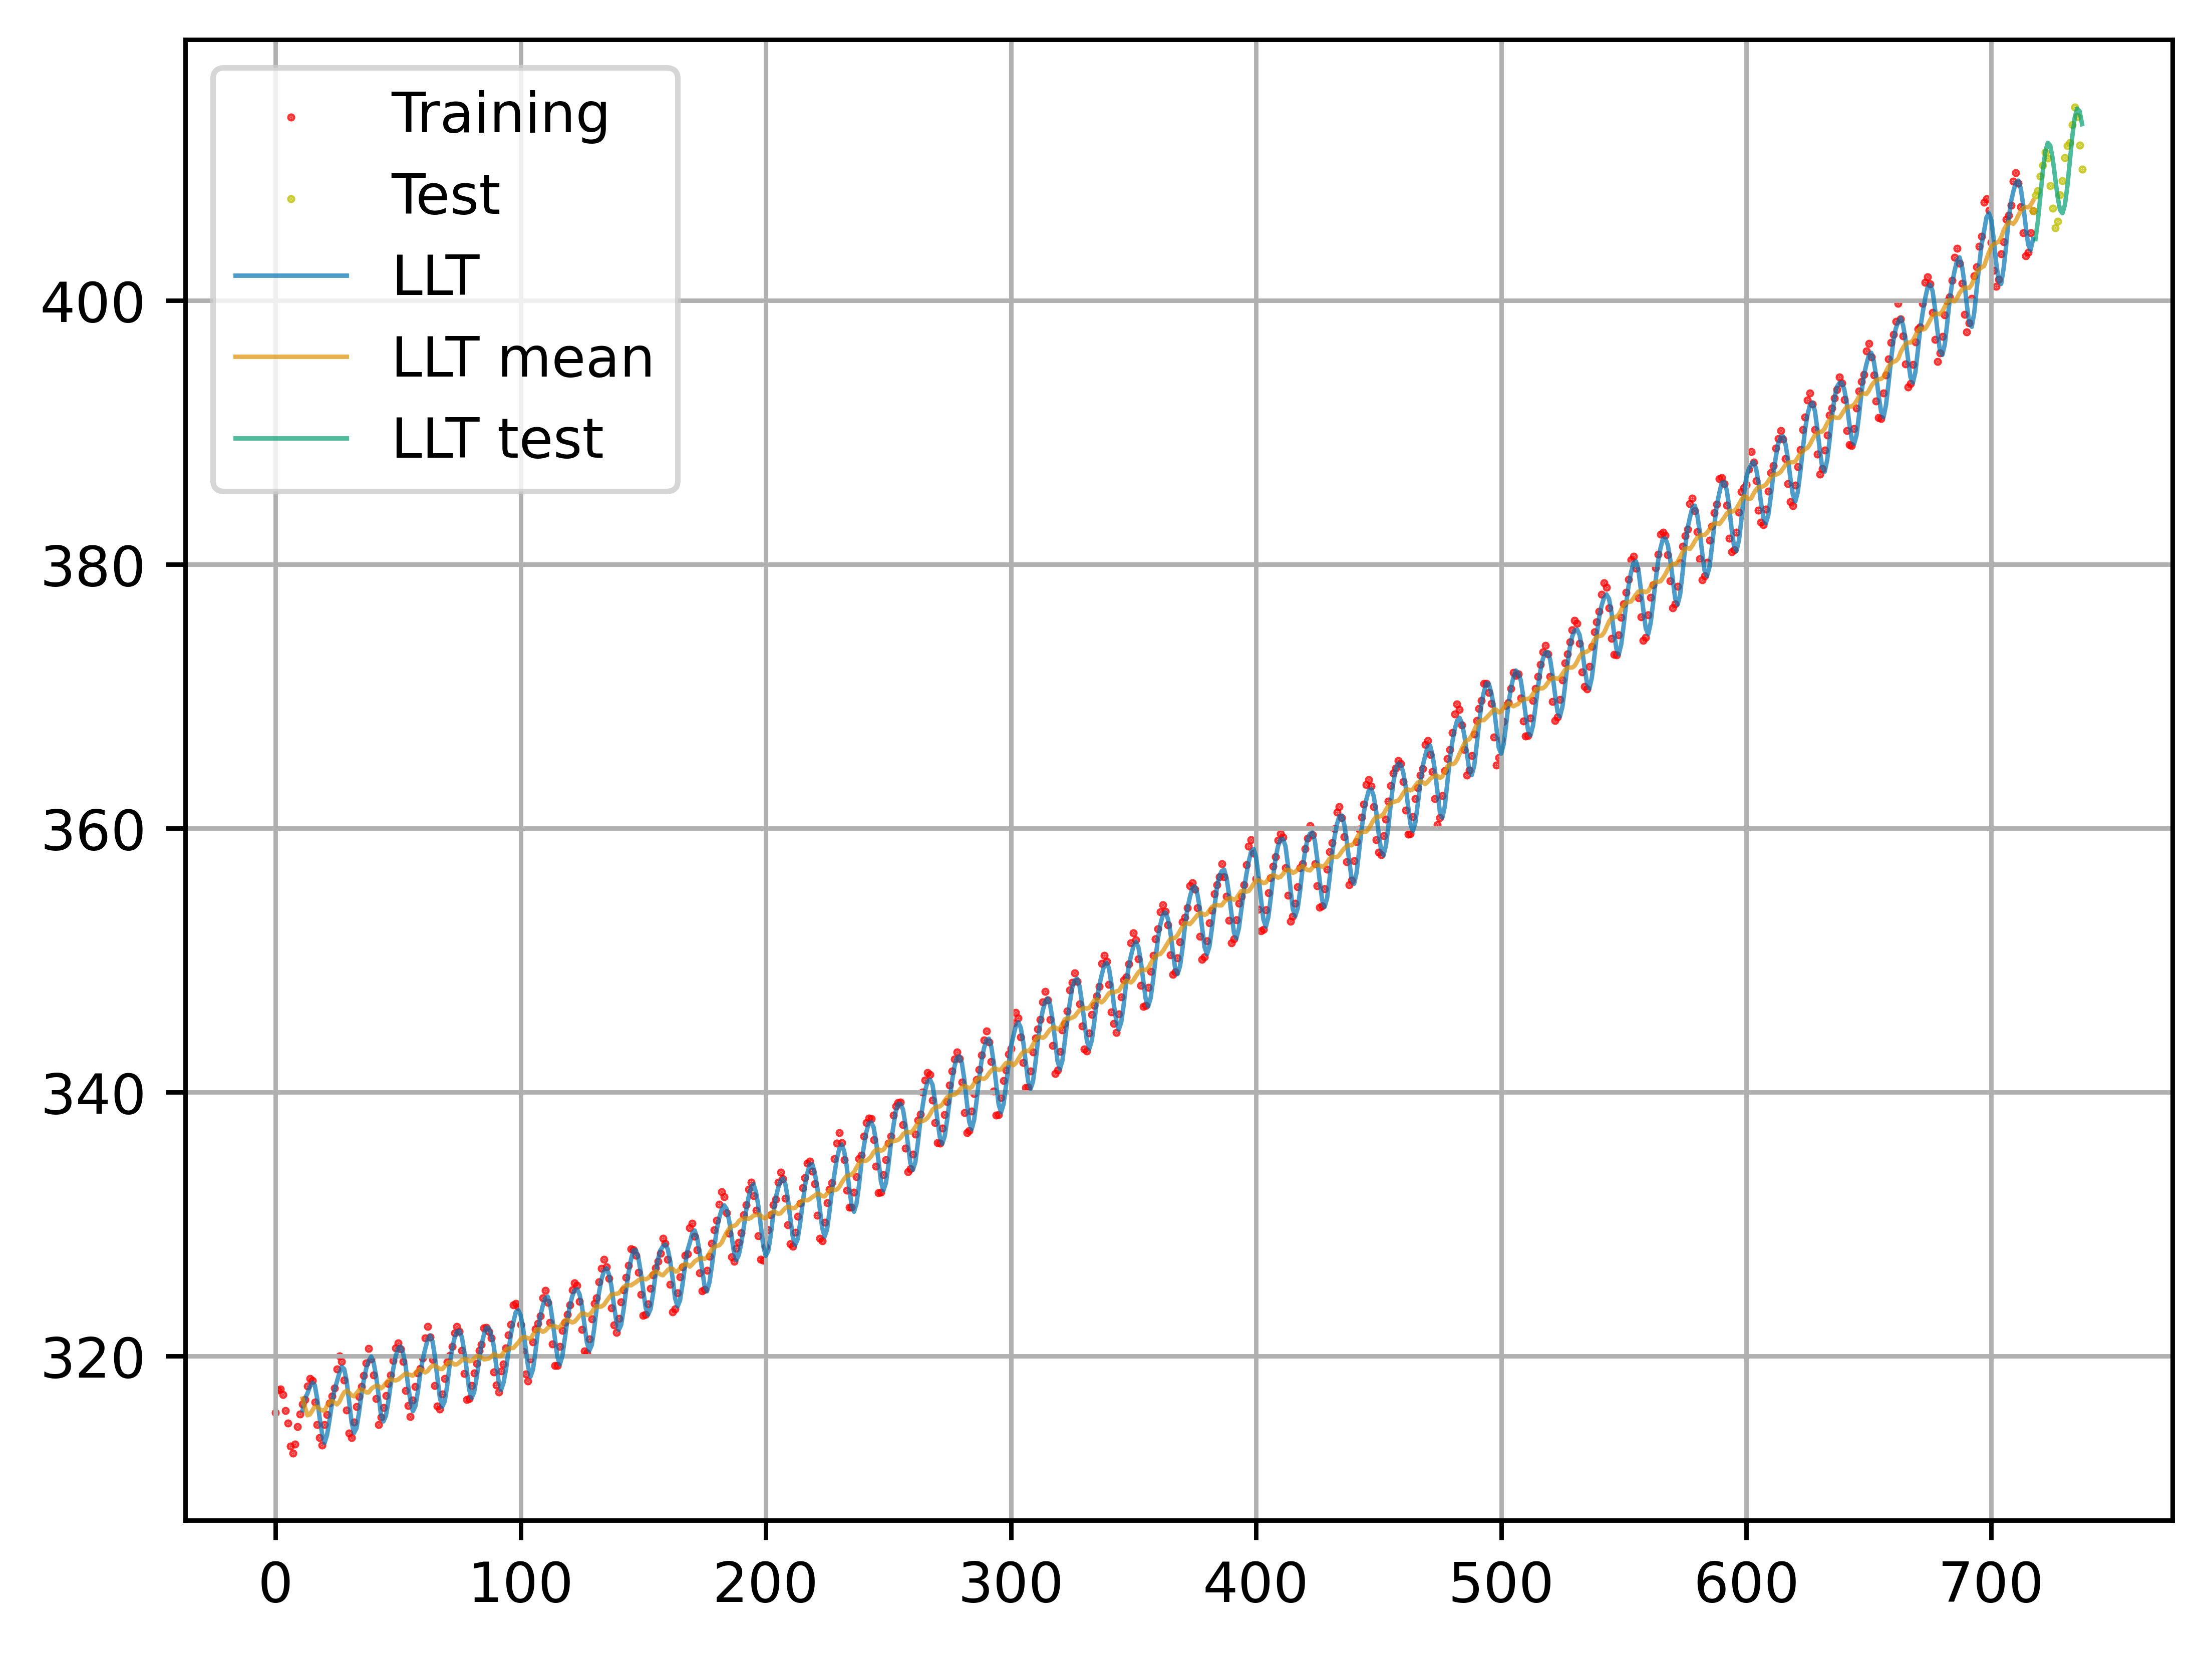

In [13]:
# Set plot options
plt.figure(dpi=800)
sns.set_palette("colorblind")

plot_model_params = {"alpha": 0.7, "linestyle": '-', "linewidth": 0.8}
plot_data_params = {"alpha": 0.8, "s": 0.2}


# Plot data
plt.scatter(time_train, co2_train, label="Training", c="r", **plot_data_params)
plt.scatter(np.concatenate([time_train[-1, None], time_test]), np.concatenate([co2_train[-1, None], co2_test]), label="Test", c='y', **plot_data_params)

# Plot model predictions
plt.plot(time_train[burn_in_1+1:], llt_y_pred_train, label="LLT", **plot_model_params)
plt.plot(time_train[burn_in_1+1:], llt_y_pred_train_mean, label="LLT mean", **plot_model_params)
plt.plot(time_test.squeeze(), llt_y_pred_test, label="LLT test", **plot_model_params)
# plt.plot(time_train, X_train @ ols_param, label="OLS", **plot_model_params)
# plt.plot(time_train, X_train @ wls_param, label="WLS", **plot_model_params)


# Plot
plt.legend()
plt.grid()

plt.show()
